In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
data = pd.read_csv("figure1_mean.csv")

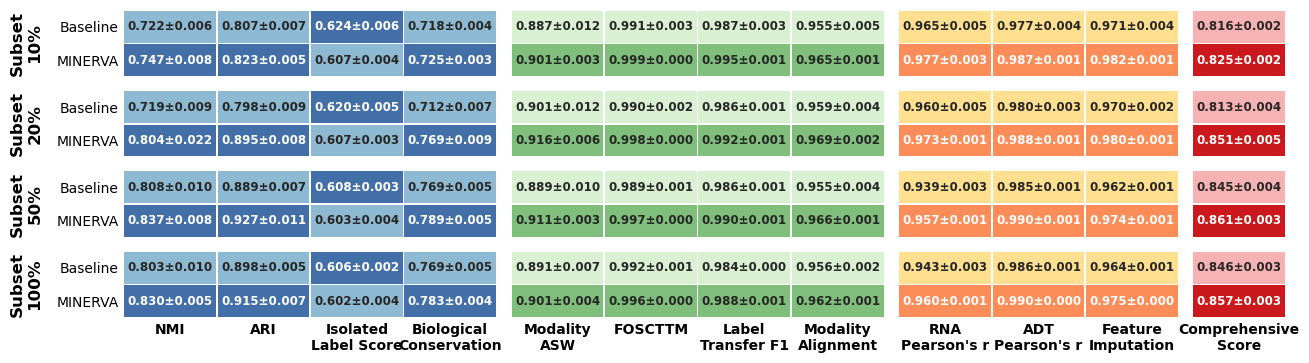

In [ ]:
data.columns = data.columns.str.strip()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.strip()

data.columns = ['Subset Ratio', 'Model', 'NMI', 'ARI', 'Isolated\nLabel Score',
       'Biological\nConservation', 'Modality\nASW', 'FOSCTTM',
       'Label\nTransfer F1', 'Modality\nAlignment', 'RNA\nPearson\'s r',
       'ADT\nPearson\'s r', 'Feature\nImputation', 'Comprehensive\nScore']

metric_groups = {
    "Biological\nConservation": ['NMI', 'ARI', 'Isolated\nLabel Score', 'Biological\nConservation'],
    "Modality\nAlignment": ['Modality\nASW', 'FOSCTTM', 'Label\nTransfer F1', 'Modality\nAlignment'],
    "Feature\nImputation": ['RNA\nPearson\'s r', 'ADT\nPearson\'s r', 'Feature\nImputation'],
    "Comprehensive\nScore": ['Comprehensive\nScore']
}

cmap_list = [['#436fa9', '#8eb9d3'], ['#7fbf7b', '#d9f0d3'], ['#fc8d59','#fee090'], ['#cb181d', '#F7B3B3']]
batch_list = ['10%', '20%', '50%', '100%']
model_order = ['Baseline', 'MINERVA']

fig, axes = plt.subplots(4, 4, sharey='row', gridspec_kw={'width_ratios':[4, 4, 3, 1]}, figsize=(15, 4))
plt.subplots_adjust(wspace = 0.05, hspace = 0.2)

for col_idx, (group_name, metrics) in enumerate(metric_groups.items()):
    current_cmap = ListedColormap(cmap_list[col_idx])
    
    for row_idx, sampling_ratio in enumerate(batch_list):
        ax = axes[row_idx, col_idx]
        
        _data = data[data['Subset Ratio'] == sampling_ratio].copy()
        
        # 将指标列转换为数值类型
        for metric in metrics:
            _data[metric] = pd.to_numeric(_data[metric], errors='coerce')
        
        # 按模型分组计算均值和方差
        grouped = _data.groupby('Model')
        data_mean = grouped[metrics].mean().reindex(model_order)
        data_std = grouped[metrics].std().reindex(model_order)

        # 创建用于颜色映射的排名数据（均值越高，排名越靠前，值为1）
        data_ranked = data_mean.rank(axis=0, ascending=False, method='min').astype(int)

        # 创建用于注释的文本（格式：mean±std）
        annot_labels = pd.DataFrame(index=data_mean.index, columns=data_mean.columns)
        for model in data_mean.index:
            for metric in data_mean.columns:
                mean_val = data_mean.loc[model, metric]
                std_val = data_std.loc[model, metric]
                # 使用.4f确保方差的小数位数足够，避免显示为0.000
                annot_labels.loc[model, metric] = f"{mean_val:.3f}±{std_val:.3f}"

        # 判断是否显示X轴刻度标签（只在最底下一行显示）
        xticklabels = row_idx == len(batch_list) - 1
        
        # 绘制热图
        sns.heatmap(data_ranked, annot=annot_labels, fmt='', cmap=current_cmap, ax=ax,
                    annot_kws={"fontsize": 8.5, "fontweight": 'bold'},
                    linewidths=0.5, linecolor='white', cbar=False, xticklabels=xticklabels)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='y', rotation=0, length=0) # Y轴刻度标签水平显示
        ax.tick_params(axis='x', length=0)

        # 如果是第一列，设置行标题
        if col_idx == 0:
            ax.set_ylabel("Subset\n" + sampling_ratio, rotation=90, fontsize=12, fontweight='bold', labelpad=10)
        
        # 如果是最后一行，旋转X轴标签防止重叠
        if xticklabels:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10, fontweight='bold')
plt.savefig('figure1_mean.svg', dpi = 300, bbox_inches = 'tight')
plt.show()